# Team Members:
1- Roba Gamal Mohamed

2- Eman Hosam Adel

3- Abdel-Rahman Sayed Kaseb

Video Link: https://drive.google.com/file/d/19wWup-XlTstB4BAIs1qq2vqCNCD_qiAx/view?usp=sharing

Our GitHub Code Link: https://github.com/emhos/Assignment1_ELC780

References: https://github.com/jacobgil/keras-grad-cam

In [1]:
!wget http://farm4.staticflickr.com/3054/2571342305_e99a8cc937_z.jpg
!wget https://farm4.staticflickr.com/3634/4052621372_f64ef93034_z.jpg
!wget https://farm6.staticflickr.com/5060/5542673585_3a15803583_z.jpg
!mv 2571342305_e99a8cc937_z.jpg cat.jpg
!mv 4052621372_f64ef93034_z.jpg dog.jpg
!mv 5542673585_3a15803583_z.jpg elephant.jpg

--2021-10-30 20:50:04--  http://farm4.staticflickr.com/3054/2571342305_e99a8cc937_z.jpg
Resolving farm4.staticflickr.com (farm4.staticflickr.com)... 13.32.201.87, 2600:9000:2199:ea00:0:5a51:64c9:c681, 2600:9000:2199:9e00:0:5a51:64c9:c681, ...
Connecting to farm4.staticflickr.com (farm4.staticflickr.com)|13.32.201.87|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm4.staticflickr.com/3054/2571342305_e99a8cc937_z.jpg [following]
--2021-10-30 20:50:04--  https://farm4.staticflickr.com/3054/2571342305_e99a8cc937_z.jpg
Connecting to farm4.staticflickr.com (farm4.staticflickr.com)|13.32.201.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘2571342305_e99a8cc937_z.jpg’

2571342305_e99a8cc9     [ <=>                ]  80.41K  --.-KB/s    in 0.02s   

2021-10-30 20:50:04 (3.70 MB/s) - ‘2571342305_e99a8cc937_z.jpg’ saved [82336]

--2021-10-30 20:50:04--  https://farm4.staticflickr

In [2]:
!pip install tf-explain

In [3]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.models import Model
from keras.preprocessing import image
from keras.layers.core import Lambda
from tensorflow.keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## GradCam

In [4]:
def _compute_gradients(tensor, var_list):
    grads = tf.gradients(tensor, var_list)
    return [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(var_list, grads)]

def grad_cam(input_model, image, category_index, layer_name):
    nb_classes = 1000
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    x = Lambda(target_layer, output_shape = target_category_loss_output_shape)(input_model.output)
    model = Model(inputs=input_model.input, outputs=x)
    model.summary()
    loss = K.sum(model.output)
    conv_output =  [l for l in model.layers if l.name is layer_name][0].output
    grads = normalize(_compute_gradients(loss, [conv_output])[0])
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap


## Classification tasks
-Use VGG16 model pretrained on imagenet to predict the classes of 3 images


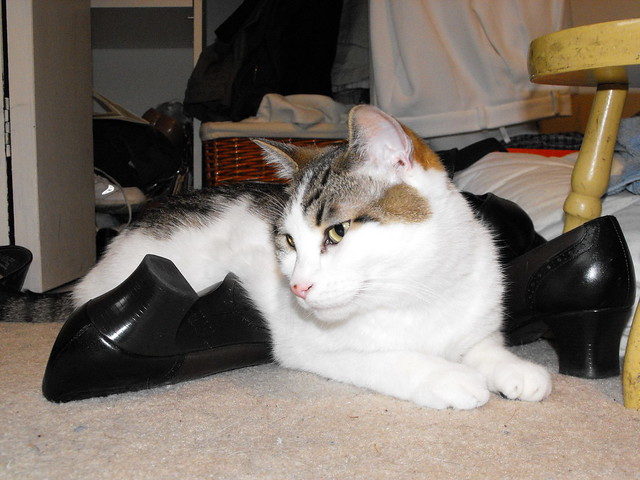

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Predicted class:
tiger_cat (n02123159) with probability 0.12


In [5]:
from google.colab.patches import cv2_imshow ## HERE
preprocessed_input = load_image('cat.jpg') # HERE
tf.compat.v1.disable_eager_execution()
model = VGG16(weights='imagenet') # HERE
cv2_imshow(cv2.imread('cat.jpg'))
predictions = model.predict(preprocessed_input) # HERE
top_1 = decode_predictions(predictions)[0][0]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))


In [6]:
predicted_class = np.argmax(predictions) # HERE
cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block5_conv3")
cv2.imwrite("gradcam_cat.jpg", cam)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

True

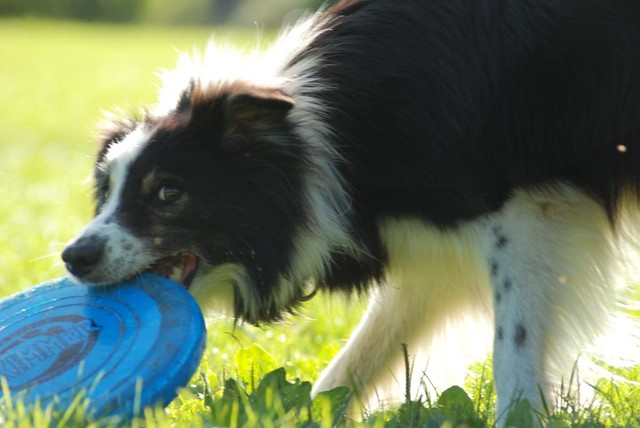

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Predicted class:
Border_collie (n02106166) with probability 0.78


In [7]:
from google.colab.patches import cv2_imshow
preprocessed_input = load_image('dog.jpg')
tf.compat.v1.disable_eager_execution()
model = VGG16(weights='imagenet')
cv2_imshow(cv2.imread('dog.jpg'))
predictions = model.predict(preprocessed_input)
top_1 = decode_predictions(predictions)[0][0]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))


In [8]:
predicted_class = np.argmax(predictions) # HERE
cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block5_conv3")
cv2.imwrite("gradcam_dog.jpg", cam)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

True

In [9]:
preprocessed_input = load_image('elephant.jpg')
tf.compat.v1.disable_eager_execution()
model = VGG16(weights='imagenet')

predictions = model.predict(preprocessed_input)
top_1 = decode_predictions(predictions)[0][0]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Predicted class:
Indian_elephant (n02504013) with probability 0.19


In [10]:
predicted_class = np.argmax(predictions) # HERE
cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block5_conv3")
cv2.imwrite("gradcam_elephant.jpg", cam)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

True